In [1]:
#importing the necessary dependencies

from caffe.proto import caffe_pb2
from layers import Fixations
from urllib import urlretrieve
from utils import *
import caffe
import os

%matplotlib inline

In [2]:
#initializing the model

# Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

model_path = os.path.join('../models', 'bvlc_alexnet', 'bvlc_alexnet.caffemodel')
if not os.path.isfile(model_path):
        print('Downloading AlexNet weights...')
        urlretrieve ("http://dl.caffe.berkeleyvision.org/bvlc_alexnet.caffemodel", model_path)

net = caffe.Classifier('../models/bvlc_alexnet/deploy.prototxt', model_path, channel_swap=(2,1,0))
layers = Fixations(net)

In [3]:
def alexNet(points, inc, resFac):
    points = layers.fc(points=points, layer='fc8', prevLayer='fc7')
    points = layers.fc(points=points, layer='fc7', prevLayer='fc6')
    points = layers.fc(points=points, layer='fc6', prevLayer='pool5')
    points = layers.pool(points=points, prevLayer='conv5', K=3, S=2)
    points = layers.conv(points=points,  layer='conv5', prevLayer='conv4', K=3, S=1, P=1, group=True)
    points = layers.conv(points=points,  layer='conv4', prevLayer='conv3', K=3, S=1, P=1, group=True)
    points = layers.conv(points=points,  layer='conv3', prevLayer='pool2', K=3, S=1, P=1)
    points = layers.pool(points=points, prevLayer='conv2', K=3, S=2)
    points = layers.conv(points=points,  layer='conv2', prevLayer='pool1', K=5, S=1, P=2, group=True)
    points = layers.pool(points=points, prevLayer='conv1', K=3, S=2)
    points = layers.conv(points=points,  layer='conv1', prevLayer='data', K=11, S=4, P=0)
    points = layers.data(points=points, inc=inc, resFac=resFac)
    return points

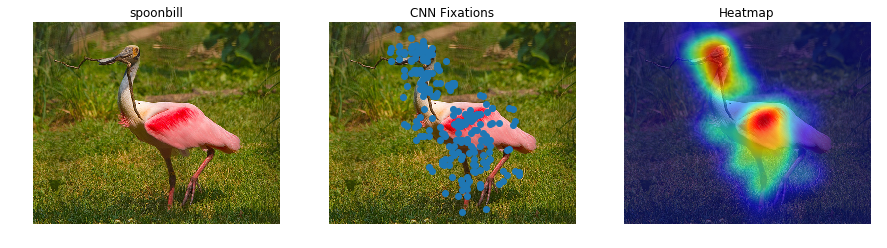

In [8]:
img_path = '../../data/ILSVRC_Validation/Images/ILSVRC2012_val_00000043.JPEG'
img, offset, resFac, newSize = imgPreprocess(img_path=img_path, size=227)
net.image_dims = newSize
points, image_label = pred(net, img)
points = alexNet(points, offset, resFac)
visualize(img_path, points, diag_percent=0.1, image_label=image_label)